In [4]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.9.1


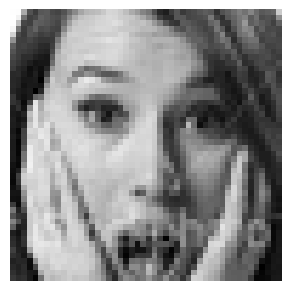

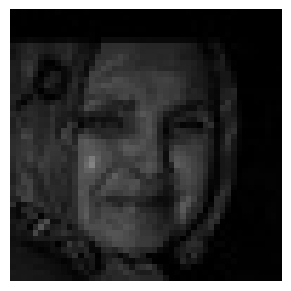

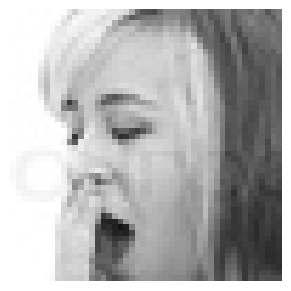

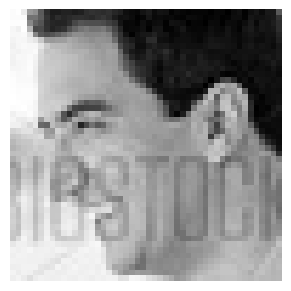

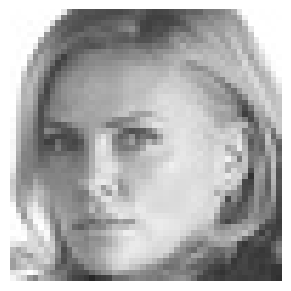

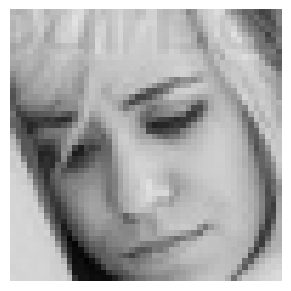

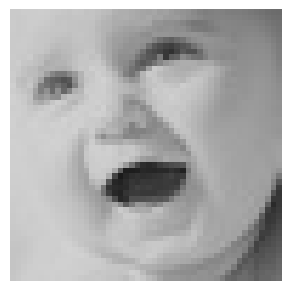

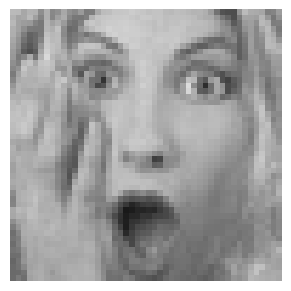

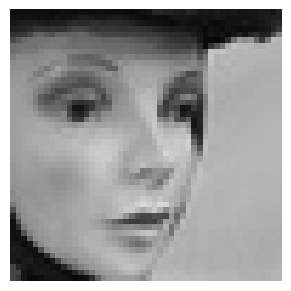

In [2]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)); plt.axis('off')

In [5]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory(
    "train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory(
    "test/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    return x
    
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x




def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(conv_1, 64, (5,5))
    conv_3 = Convolution(conv_2, 128, (3,3))

    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten, 256)

    output = Dense(7, activation="softmax")(dense_1)

    model = Model(inputs=[inputs], outputs=[output])

    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])
    return model
model = model_fer((48,48,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]


In [9]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6967 - accuracy: 0.3499   
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 511s 1s/step - loss: 1.6967 - accuracy: 0.3499 - val_loss: 1.4768 - val_accuracy: 0.4395
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4104 - accuracy: 0.4604  
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 115s 256ms/step - loss: 1.4104 - accuracy: 0.4604 - val_loss: 1.4873 - val_accuracy: 0.4227
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.5100  
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 132s 295ms/step - loss: 1.2838 - accuracy: 0.5100 - val_loss: 1.2870 - val_accuracy: 0.4967
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2151 - accuracy: 0.5396  
Epoch 4: saving model to model_weights.h5
448/448 [============================

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 8s 75ms/step - loss: 1.0731 - accuracy: 0.6187


[1.073099136352539, 0.6186960339546204]

In [11]:
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [12]:
import matplotlib.pyplot as plt



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
15


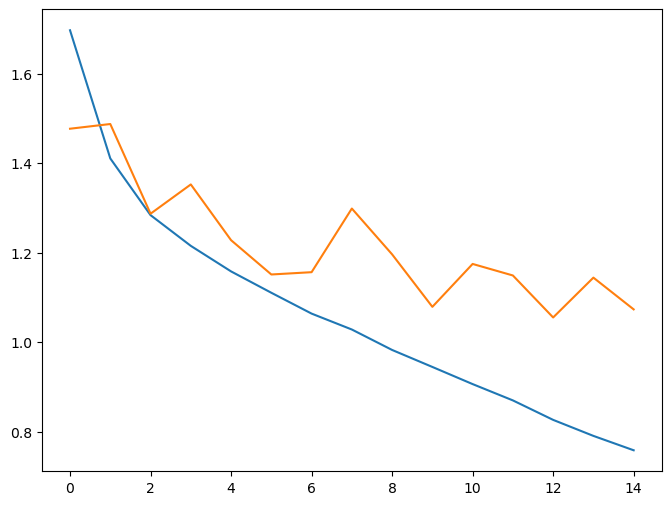

In [13]:
import pickle

with open('training_history.pkl', 'rb') as f:
    hist = pickle.load(f)

print(hist.keys())
print(len(hist['loss']))

plt.figure(figsize=(8,6))
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


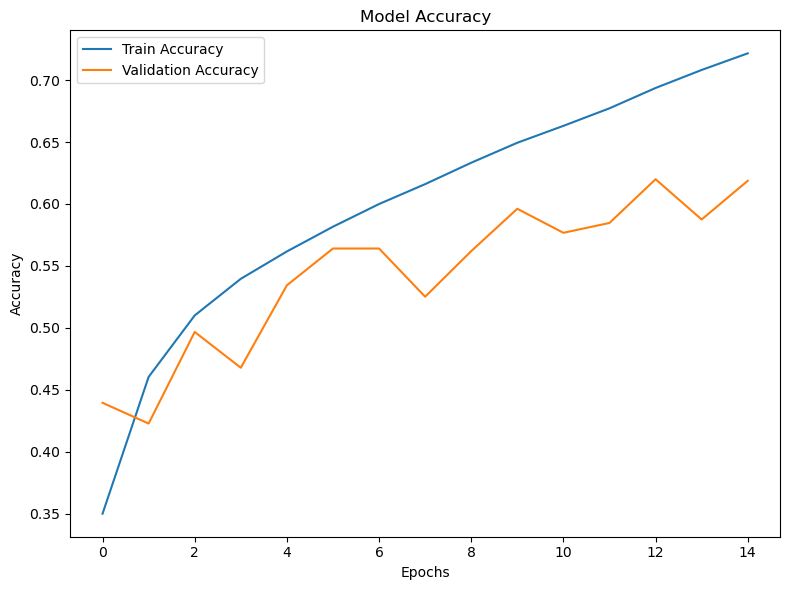

In [14]:
# Good practice: check keys first
print(history.history.keys())

# Or if loading from .pkl
# with open('training_history.pkl', 'rb') as f:
#     hist = pickle.load(f)

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.tight_layout()  # Handles spacing automatically
plt.show()


In [15]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)